# Model validation

In this notebook, we validate the model that we have trained before

In [7]:
from pathlib import Path
import os
from PIL import Image
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "../data/test"
labels = ['fresh','blackspot','canker','grenning']
model_file = '../models/mobilenet_v2_epoch_9.pth'

## Load test dataset

In this part, we load the test data.

In [8]:
# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
])

class OrangeDiseaseDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.data = []
        self._load_images()

    def _load_images(self):
        for label in labels:
            label_dir = os.path.join(self.data_dir,label)
            [self.data.append((img_path, label)) for ext in ['*.jpg','*.png'] for img_path in Path(label_dir).rglob(ext)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = self.labels.index(label)
        return image, label_idx

# Create dataset
dataset = OrangeDiseaseDataset(data_dir, labels, transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
print(test_loader)

## Load the model


In [9]:
# Load the trained model
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(labels))
model.load_state_dict(torch.load(model_file))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
model.eval()

/home/vscode/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_121960/482733057.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This

cuda:0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Print evaluation report

In [10]:
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, target_names in test_loader:
        inputs, target_names = inputs.to(device), target_names.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target_names.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=labels))

              precision    recall  f1-score   support

       fresh       0.87      1.00      0.93        33
   blackspot       0.80      0.91      0.85        22
      canker       1.00      0.64      0.78        22
    grenning       1.00      1.00      1.00        22

    accuracy                           0.90        99
   macro avg       0.92      0.89      0.89        99
weighted avg       0.91      0.90      0.89        99



## Confusion matrix

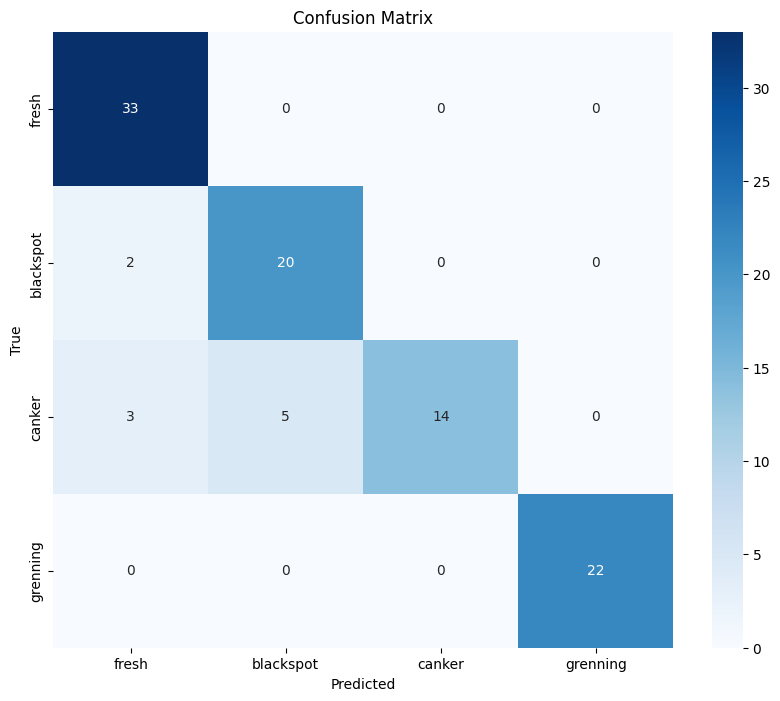

In [11]:
conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print all missclassified images

../data/test/blackspot/b (3).jpg


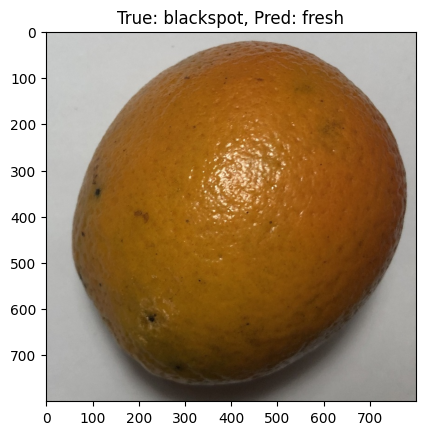

../data/test/blackspot/b (5).jpg


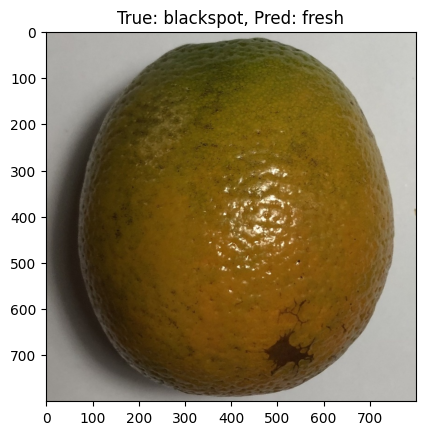

../data/test/canker/c (1).jpg


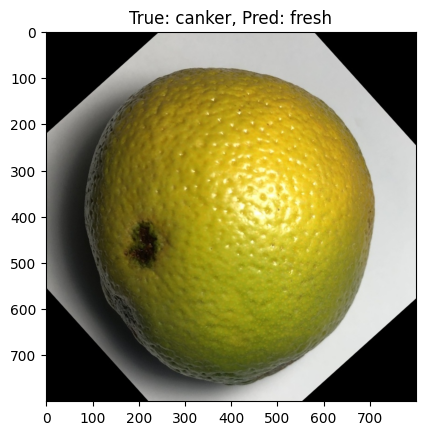

../data/test/canker/c (11).jpg


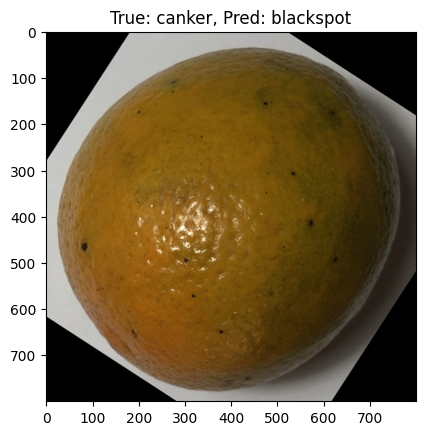

../data/test/canker/c (12).jpg


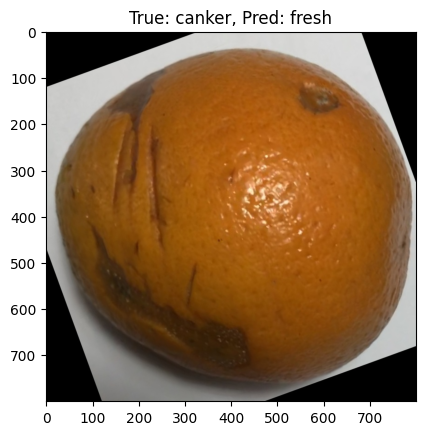

../data/test/canker/c (16).jpg


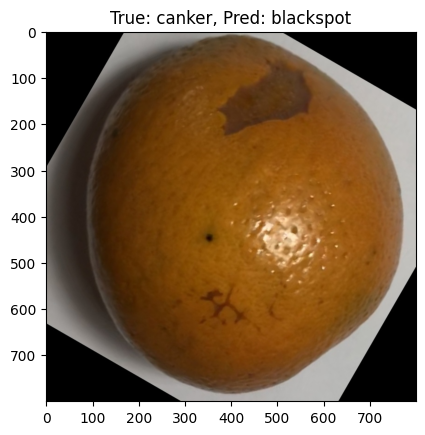

../data/test/canker/c (17).jpg


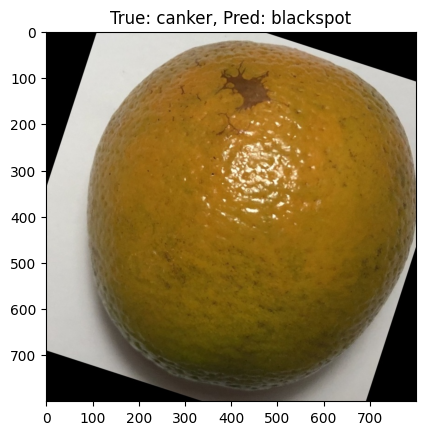

../data/test/canker/c (19).jpg


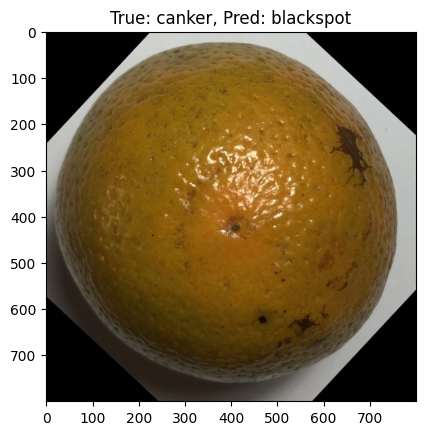

../data/test/canker/c (2).jpg


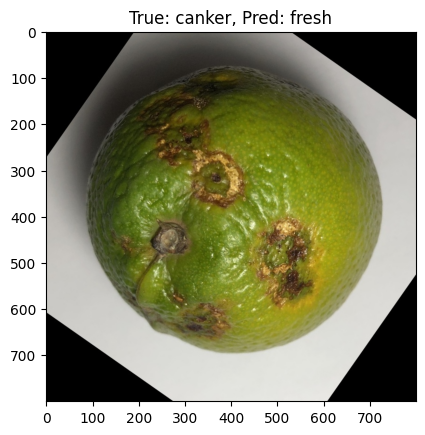

../data/test/canker/c (8).jpg


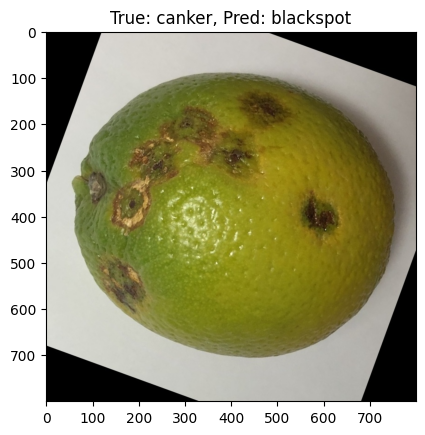

In [12]:
misclassified_images = []
misclassified_labels = []
misclassified_preds = []
for label, pred, img_path in zip(all_labels, all_preds, dataset.data):
    if label != pred:
        misclassified_images.append(img_path[0])
        misclassified_labels.append(label)
        misclassified_preds.append(pred)

# Display misclassified images
def imshow(img, title=None):
    """Helper function to show an image"""
    print(img)
    plt.imshow(Image.open(img))
    if title:
        plt.title(title)
    plt.show()

# Display the first 10 misclassified images
num_images = min(len(misclassified_images), 10)
for i in range(num_images):
    imshow(misclassified_images[i], title=f'True: {labels[misclassified_labels[i]]}, Pred: {labels[misclassified_preds[i]]}')

